<a href="https://colab.research.google.com/github/xin-wen-eng/Automated-Concrete-Crack-Detection-System/blob/main/Project_Concrete_Crack_Detection_using_Custom_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# =============================================================================
# PROJECT: Concrete Crack Detection using Custom CNN
# AUTHOR: Xin Wen
# ENVIRONMENT: Google Colab (PyTorch)
# DESCRIPTION: End-to-end pipeline from data extraction to inference.
# =============================================================================

# --- SECTION 1: SETUP & INFRASTRUCTURE ---
# Purpose: Import libraries, mount drive, and configure computation device.

import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split
from PIL import Image
from tqdm.notebook import tqdm  # Progress bar for Colab

# 1.1 Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 1.2 Configuration
# Path to the zip file in your Google Drive
ZIP_PATH = '/content/drive/MyDrive/concerete_crack_images-3-1.zip'
# Directory to extract files locally in Colab (faster I/O than reading from Drive)
EXTRACT_PATH = '/content/dataset_root'

# Hyperparameters
BATCH_SIZE = 64
EPOCHS = 10
LEARNING_RATE = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"✅ Setup Complete. Using Device: {DEVICE}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Setup Complete. Using Device: cuda


In [ ]:
# --- SECTION 2: DATA PREPARATION ---
# Purpose: Unzip data and define directory paths based on the screenshot structure.

print("\n--- Extracting Dataset ---")
if not os.path.exists(EXTRACT_PATH):
    os.makedirs(EXTRACT_PATH)

# Extracting the zip file
with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
    zip_ref.extractall(EXTRACT_PATH)
print("✅ Extraction Complete.")

# Clean up macOS specific hidden files (._*)
print("✨ Cleaning up macOS specific hidden files (._*) ...")
for root, _, files in os.walk(EXTRACT_PATH):
    for file in files:
        if file.startswith('._'):
            os.remove(os.path.join(root, file))
print("✅ Cleanup Complete.")

# 2.1 Define Data Directories
# Note: We need to be careful to avoid the __MACOSX directory if it exists at the root of the extracted path.
train_dir = None
test_dir = None

# Find the actual root directory containing 'training' and 'test'
data_root_found = False
for entry in os.listdir(EXTRACT_PATH):
    current_path = os.path.join(EXTRACT_PATH, entry)
    # Prioritize non-__MACOSX directories
    if os.path.isdir(current_path) and entry != '__MACOSX':
        if os.path.exists(os.path.join(current_path, 'training')) and \
           os.path.exists(os.path.join(current_path, 'test')):
            train_dir = os.path.join(current_path, 'training')
            test_dir = os.path.join(current_path, 'test')
            data_root_found = True
            break

# If not found directly under a non-__MACOSX subfolder, check EXTRACT_PATH itself
if not data_root_found:
    if os.path.exists(os.path.join(EXTRACT_PATH, 'training')) and \
       os.path.exists(os.path.join(EXTRACT_PATH, 'test')):
        train_dir = os.path.join(EXTRACT_PATH, 'training')
        test_dir = os.path.join(EXTRACT_PATH, 'test')
        data_root_found = True

# If still not found, search within non-__MACOSX subdirectories more broadly
if not data_root_found:
    for root, dirs, files in os.walk(EXTRACT_PATH):
        # Skip __MACOSX directories and their contents during the search for data root
        if '__MACOSX' in root:
            continue
        if 'training' in dirs and 'test' in dirs:
            train_dir = os.path.join(root, 'training')
            test_dir = os.path.join(root, 'test')
            data_root_found = True
            break

if not data_root_found:
    raise FileNotFoundError(f"❌ Could not locate 'training' and 'test' directories within {EXTRACT_PATH}")

print(f"📂 Training Directory: {train_dir}")
print(f"📂 Testing Directory:  {test_dir}")

# Verify classes (Should be 'Negative' and 'Positive')
if os.path.exists(train_dir):
    classes = sorted(os.listdir(train_dir))
    print(f"🏷️  Classes Found: {classes}")
else:
    raise FileNotFoundError(f"❌ Could not find training directory at {train_dir}")


--- Extracting Dataset ---
✅ Extraction Complete.
✨ Cleaning up macOS specific hidden files (._*) ...
✅ Cleanup Complete.
📂 Training Directory: /content/dataset_root/concerete_crack_images/training
📂 Testing Directory:  /content/dataset_root/concerete_crack_images/test
🏷️  Classes Found: ['.DS_Store', 'Negative', 'Positive']


In [ ]:
# --- SECTION 3: DATA TRANSFORMS & LOADERS ---
# Purpose: Preprocess images (Resize, Normalize) and split into Train/Val sets.

# 3.1 Define Transforms (Augmentation for Train, Standard for Val)
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# 3.2 Custom Wrapper to apply specific transforms to split subsets
class TransformedSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

# Custom function to filter out macOS specific hidden files (._*)
def is_valid_image_file(path):
    if os.path.basename(path).startswith('._'):
        return False
    # Ensure it's an actual image file (e.g., ends with common image extensions)
    IMG_EXTENSIONS = ('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')
    return path.lower().endswith(IMG_EXTENSIONS)

# 3.3 Load and Split Data
full_dataset = datasets.ImageFolder(train_dir, is_valid_file=is_valid_image_file)
train_idx, val_idx = train_test_split(
    list(range(len(full_dataset))),
    test_size=0.2,
    stratify=full_dataset.targets,
    random_state=42
)

train_data = TransformedSubset(Subset(full_dataset, train_idx), transform=data_transforms['train'])
val_data = TransformedSubset(Subset(full_dataset, val_idx), transform=data_transforms['val'])

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"📊 Data Loaded: {len(train_data)} Training images, {len(val_data)} Validation images.")

📊 Data Loaded: 25685 Training images, 6422 Validation images.


In [ ]:
# --- SECTION 4: MODEL ARCHITECTURE ---
# Purpose: Define a Convolutional Neural Network (CNN).

class CrackCNN(nn.Module):
    def __init__(self):
        super(CrackCNN, self).__init__()
        # Convolutional Blocks
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        # Utilities
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)

        # Fully Connected Layers
        # Input: 224x224 -> pool/2 (112) -> pool/2 (56) -> pool/2 (28) -> pool/2 (14)
        # Final Feature Map: 128 channels * 14 * 14
        self.fc1 = nn.Linear(128 * 14 * 14, 512)
        self.fc2 = nn.Linear(512, 2) # 2 Classes: Negative, Positive

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))

        x = x.view(-1, 128 * 14 * 14) # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = CrackCNN().to(DEVICE)
print("🧠 Model Architecture Initialized.")

🧠 Model Architecture Initialized.


In [ ]:
# --- SECTION 5: TRAINING LOOP ---
# Purpose: Train the model and track performance metrics.

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_acc = 0.0

print(f"\n🚀 Starting Training for {EPOCHS} Epochs...")

for epoch in range(EPOCHS):
    model.train()
    running_loss, running_corrects = 0.0, 0

    # Training Phase
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]", leave=False):
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_data)
    epoch_acc = running_corrects.double() / len(train_data)

    # Validation Phase
    model.eval()
    val_loss, val_corrects = 0.0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)

    val_loss_epoch = val_loss / len(val_data)
    val_acc_epoch = val_corrects.double() / len(val_data)

    # Store History
    history['train_loss'].append(epoch_loss)
    history['train_acc'].append(epoch_acc.item())
    history['val_loss'].append(val_loss_epoch)
    history['val_acc'].append(val_acc_epoch.item())

    print(f"   End Epoch {epoch+1} -> Train Acc: {epoch_acc:.4f} | Val Acc: {val_acc_epoch:.4f}")

    # Save Best Model
    if val_acc_epoch > best_acc:
        best_acc = val_acc_epoch
        torch.save(model.state_dict(), 'best_model.pth')

print(f"\n🏆 Training Complete. Best Validation Accuracy: {best_acc:.4f}")


🚀 Starting Training for 10 Epochs...


Epoch 1/10 [Train]:   0%|          | 0/402 [00:00<?, ?it/s]

   End Epoch 1 -> Train Acc: 0.9758 | Val Acc: 0.9841


Epoch 2/10 [Train]:   0%|          | 0/402 [00:00<?, ?it/s]

   End Epoch 2 -> Train Acc: 0.9913 | Val Acc: 0.9947


Epoch 3/10 [Train]:   0%|          | 0/402 [00:00<?, ?it/s]

   End Epoch 3 -> Train Acc: 0.9935 | Val Acc: 0.9960


Epoch 4/10 [Train]:   0%|          | 0/402 [00:00<?, ?it/s]

   End Epoch 4 -> Train Acc: 0.9951 | Val Acc: 0.9936


Epoch 5/10 [Train]:   0%|          | 0/402 [00:00<?, ?it/s]

   End Epoch 5 -> Train Acc: 0.9954 | Val Acc: 0.9981


Epoch 6/10 [Train]:   0%|          | 0/402 [00:00<?, ?it/s]

   End Epoch 6 -> Train Acc: 0.9966 | Val Acc: 0.9977


Epoch 7/10 [Train]:   0%|          | 0/402 [00:00<?, ?it/s]

   End Epoch 7 -> Train Acc: 0.9957 | Val Acc: 0.9893


Epoch 8/10 [Train]:   0%|          | 0/402 [00:00<?, ?it/s]

   End Epoch 8 -> Train Acc: 0.9968 | Val Acc: 0.9984


Epoch 9/10 [Train]:   0%|          | 0/402 [00:00<?, ?it/s]

   End Epoch 9 -> Train Acc: 0.9972 | Val Acc: 0.9980


Epoch 10/10 [Train]:   0%|          | 0/402 [00:00<?, ?it/s]

   End Epoch 10 -> Train Acc: 0.9972 | Val Acc: 0.9945

🏆 Training Complete. Best Validation Accuracy: 0.9984


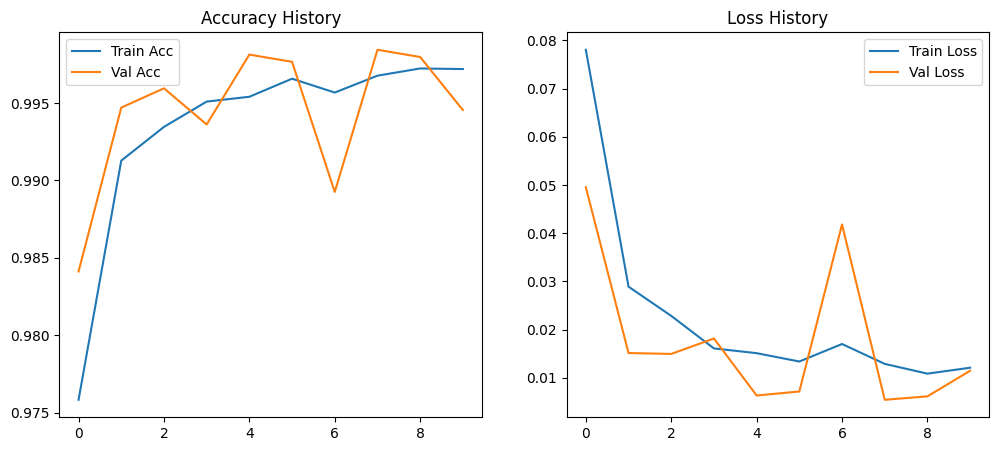

In [ ]:
# --- SECTION 6: VISUALIZATION ---
# Purpose: Plot training curves to check for overfitting/underfitting.

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.title('Accuracy History')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss History')
plt.legend()
plt.show()


🔍 Running inference on 7893 test images...


Predicting:   0%|          | 0/124 [00:00<?, ?it/s]


--- Visualizing Random Test Predictions ---


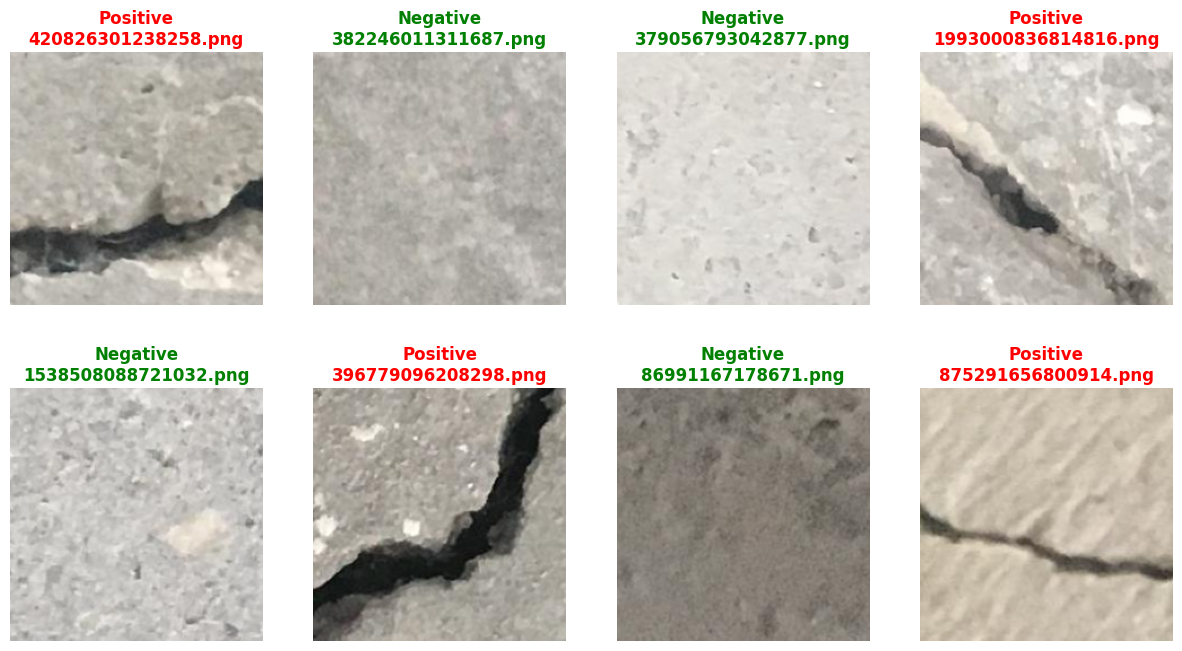

✅ Results saved to 'submission_results.csv'


In [ ]:
# --- SECTION 7: TESTING & INFERENCE ---
# Purpose: Run prediction on the unlabeled 'test' folder.

# 7.1 Custom Dataset for unlabeled test images
class TestDataset(Dataset):
    def __init__(self, dir_path, transform=None):
        self.dir_path = dir_path
        self.transform = transform
        # Only grab images
        self.image_files = [f for f in os.listdir(dir_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.dir_path, img_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, img_name

# 7.2 Run Inference
if os.path.exists(test_dir):
    test_ds = TestDataset(test_dir, transform=data_transforms['val'])
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

    print(f"\n🔍 Running inference on {len(test_ds)} test images...")

    model.load_state_dict(torch.load('best_model.pth')) # Load best weights
    model.eval()

    predictions = []
    filenames = []

    with torch.no_grad():
        for inputs, names in tqdm(test_loader, desc="Predicting"):
            inputs = inputs.to(DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            predictions.extend(preds.cpu().numpy())
            filenames.extend(names)

    # 7.3 Map predictions (0 -> Negative, 1 -> Positive)
    # Note: 'full_dataset.class_to_idx' gives us the mapping
    idx_to_class = {v: k for k, v in full_dataset.class_to_idx.items()}
    pred_labels = [idx_to_class[p] for p in predictions]

    # 7.4 Visualization of Test Results
    print("\n--- Visualizing Random Test Predictions ---")
    plt.figure(figsize=(15, 8))
    indices = np.random.choice(len(test_ds), 8, replace=False) # Pick 8 random images

    for i, idx in enumerate(indices):
        img_tensor, name = test_ds[idx]
        label = pred_labels[idx]

        ax = plt.subplot(2, 4, i+1)
        ax.axis('off')

        # Un-normalize for display
        img = img_tensor.permute(1, 2, 0).numpy()
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)

        ax.imshow(img)
        color = 'red' if label == 'Positive' else 'green'
        ax.set_title(f"{label}\n{name}", color=color, fontweight='bold')

    plt.show()

    # 7.5 Save Results to CSV
    results_df = pd.DataFrame({'Image': filenames, 'Prediction': pred_labels})
    results_df.to_csv('submission_results.csv', index=False)
    print("✅ Results saved to 'submission_results.csv'")

else:
    print(f"⚠️ Warning: Test directory empty or not found at {test_dir}")